In [ ]:
 # Price probability distribution forecaster via LSTM

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from tqdm import tqdm
import numpy as np
import pandas as pd
import math as m
from typing import List, Tuple, Optional
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/Colab Notebooks/deeplearning/models_santi"
from keras import Sequential
from keras._tf_keras.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam




Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/deeplearning/models_santi


In [ ]:
def discrete_prices(prices,delta):

    return np.arange(int(min(prices)),int(max(prices))+1,delta)

# One-hot encoding price labels
def one_hot_encoding(prices,discrete_prices) -> np.array:

    one_hot_prices = []
    for price in prices:
        one_hot = np.zeros(len(discrete_prices))
        idx = np.argmin(abs(price-discrete_prices))
        one_hot[idx] = 1.0
        one_hot_prices.append(one_hot)

    return np.array(one_hot_prices)



class Dataset(data.Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        # Return the size of the dataset
        return len(self.targets)

    def __getitem__(self, index):
        # Retrieve inputs and targets at the given index
        X = self.inputs[index]
        y = self.targets[index]

        return X, y


def create_datasets(input_data,output_data, lag_in_days, forecast_horizon_in_hours, dataset_class, p_train=0.9, p_val=0.1, p_test=0):

    assert len(input_data) == len(output_data)

    hours = len(input_data)
    lag_in_hours = lag_in_days*24
    #forecast_hours = forecast_horizon_in_days*24

    #num_train = int((hours-(24+8760+forecast_horizon_in_hours))/24*p_train)
    #num_val = int((hours-(24+8760+forecast_horizon_in_hours))/24*p_val)
    #num_test = int((hours-(24+8760+forecast_horizon_in_hours))/24*p_test)

    num_train = int((hours-lag_in_hours-forecast_horizon_in_hours)/forecast_horizon_in_hours*p_train)
    num_val = int((hours-lag_in_hours-forecast_horizon_in_hours)/forecast_horizon_in_hours*p_val)
    num_test = int((hours-lag_in_hours-forecast_horizon_in_hours)/forecast_horizon_in_hours*p_test)
    print(hours,num_train*24,num_val*24,num_train*24+num_val*24)

    # Creating features and labels dataset
    def create_features(input_data, output_data, lag_in_hours, hours):

        # features dataset to include prices from [t:t-14, t-1year-14:t-1year+14]. So from present to 2 weeks in past and what ocurred one_year before two weeks behind and ahead
        # for now (small dataset) prices from [t:t-14]
        inputs, outputs = [], []
        for i in range(12,hours,24): # features only given for clearing time t=12h everyday

            #if i+24+8760+forecast_horizon_in_hours > hours:
            #    break

            #all referenced first year (last year)
            #last_years_indices = np.arange(i+0,i+48)
            #last_months_indices = np.arange(i+24+8760-32*24,i+24+8760-28*24) # 4 sorrounding days last month
            #last_2_days_indices = np.arange(i+24+8760-48,i+24+8760)
            #feature_indices = np.concatenate([last_years_indices,last_months_indices,last_2_days_indices])

            #forecast_indices = np.arange(i+24+8760,i+24+8760+forecast_horizon_in_hours)

            #inputs.append(input_data[feature_indices,:])
            #outputs.append(output_data[forecast_indices])

            if i+lag_in_hours+forecast_horizon_in_hours > hours:
              break

            inputs.append(input_data[i:i+lag_in_hours,:])
            outputs.append(output_data[i+lag_in_hours:i+lag_in_hours+forecast_horizon_in_hours])


        return np.array(inputs), np.array(outputs)

    inputs, outputs = create_features(input_data,output_data, lag_in_hours, hours)
    training_set = dataset_class(inputs[:num_train],outputs[:num_train])
    val_set = dataset_class(inputs[num_train:num_train+num_val],outputs[num_train:num_train+num_val])
    test_set = dataset_class(inputs[-num_test:], outputs[-num_test:])

    return training_set, val_set, test_set


Num of negative values in DA price: 247 Nume of negative values in ID prices: 974
16800 15048 1656 16704
16800 15048 1656 16704
16800 15048 1656 16704


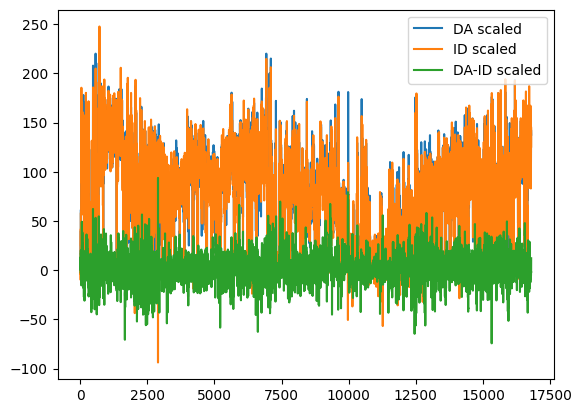

In [ ]:
data_da_23 = pd.read_csv(r'../raw_data/data_electric/data_da_23.csv')
data_id_23 = pd.read_csv(r'../raw_data/data_electric/data_id_23.csv')
data_da_24 = pd.read_csv(r'../raw_data/data_electric/data_da_24.csv')
data_id_24 = pd.read_csv(r'../raw_data/data_electric/data_id_24.csv')

data_da = pd.concat([data_da_23,data_da_24],ignore_index=True)
data_id = pd.concat([data_id_23,data_id_24],ignore_index=True)

# retriving only prices from data (not date columns)
da_prices = data_da['DA ES']
id_prices = data_id.iloc[:,-3:]

# saving date features
date_features = pd.DataFrame()
for feature in ['Month','Day','Hour']:
  data_sin_feature = data_da[feature].apply(lambda x: m.sin(x*2*m.pi/12))
  data_cos_feature = data_da[feature].apply(lambda x: m.cos(x*2*m.pi/12))
  date_features = pd.concat([date_features,data_sin_feature,data_cos_feature],axis=1)

# discretizing prices (in this case delta=1 so it is equal to rounding them to nearest integer)
da_discrete_prices = discrete_prices(da_prices,delta=1)
id_discrete_prices = list(id_prices.apply(lambda x: discrete_prices(x,delta=1), axis=0))

# setting DA price labels
da_prices_one_hot = one_hot_encoding(da_prices,da_discrete_prices)
id_prices_one_hot = [one_hot_encoding(id_prices[column],id_discrete_prices[i]) for i,column in enumerate(id_prices.columns)]

# setting datasets
lag_in_days = 2
forecast_horizon_in_hours = 24
input_data = np.hstack([np.array(date_features),np.array(da_prices).reshape(len(da_prices),1),np.array(id_prices)])
output_data_DA = np.array(da_prices).reshape(len(da_prices),1)
output_data_ID = np.array(id_prices.iloc[:,-1]).reshape(len(id_prices),1)
output_DA_diff_ID = output_data_DA - output_data_ID

print('Num of negative values in DA price:',(output_data_DA < 0).sum(),'Nume of negative values in ID prices:',(output_data_ID < 0).sum())

# log transform of input and output data
def log_transform(values):
    values = np.array(values)
    transformed = np.sign(values) * np.log(np.abs(values) + 1e-10)  # adding a small epsilon to avoid log(0)
    transformed[values == 0] = 0
    return transformed

#input_data[:,-4:] = log_transform(input_data[:,-4:])
#output_data_DA = log_transform(output_data_DA)
#output_data_ID = log_transform(output_data_ID)
#output_DA_diff_ID = log_transform(output_DA_diff_ID) # Don't know if this one or below one works better
output_DA_diff_ID = output_data_DA-output_data_ID

def minmaxscaler(inputs):

  scaler = MinMaxScaler(feature_range=(0,1))
  scaler.fit(inputs)
  inputs_scaled = scaler.transform(inputs)

  return scaler,inputs_scaled.ravel()

# Min-max scaling dataset -- LEAVING IT FOR NOW
#input_scalers = {}
#for i in range(3,input_data.shape[1],1):
#  input_scalers[i], input_data[:,i] = minmaxscaler(input_data[:,i].reshape(-1,1))

#output_scalers = {}
#for i,output in enumerate([output_data_DA,output_data_ID]):
#  output_scalers[i], output = minmaxscaler(output.reshape(-1,1))
#  if i == 0:
#    output_data_DA = output.reshape(len(da_prices),1)
#  elif i == 1:
#    output_data_ID = output.reshape(len(id_prices),1)

#output_diff_scaler, output_DA_diff_ID_scaled = minmaxscaler(output_DA_diff_ID.reshape(-1,1))
#output_DA_diff_ID = output_DA_diff_ID_scaled.reshape(len(da_prices),1)

training_set_DA, val_set_DA, test_set_DA = create_datasets(input_data,output_data_DA,lag_in_days,forecast_horizon_in_hours,Dataset)
training_set_ID, val_set_ID, test_set_ID = create_datasets(input_data,output_data_ID,lag_in_days,forecast_horizon_in_hours,Dataset)
training_set_DA_diff_ID, val_set_DA_diff_ID, test_set_DA_diff_ID = create_datasets(input_data,output_DA_diff_ID,lag_in_days,forecast_horizon_in_hours,Dataset)


#zero_inverse = output_diff_scaler.transform(np.array([0]).reshape(-1,1))
plt.plot(output_data_DA, label='DA scaled')
plt.plot(output_data_ID, label='ID scaled')
plt.plot(output_DA_diff_ID, label='DA-ID scaled')
#plt.axhline(zero_inverse,color='r')
plt.legend()
plt.show()


In [ ]:
class LSTM_multivariate_input_multi_step_forecaster(nn.Module):
    def __init__(self, input_size,hidden_size,num_layers,dropout, past_horizon, forecast_horizon):
        super().__init__()
        self.forecast_horizon = forecast_horizon

        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,dropout=dropout,batch_first=True)
        #self.lstm_autoregressive = nn.LSTM(1,hidden_size,num_layers,dropout=dropout,batch_first=True)

        self.mlp = nn.Sequential(
            nn.Linear(hidden_size,48*3),
            nn.ReLU(),
            nn.LayerNorm(48*3),
            nn.Dropout(dropout),
            nn.Linear(48*3,48*2),
            nn.ReLU(),
            nn.LayerNorm(48*2),
            nn.Dropout(dropout),
            nn.Linear(48*2,48*2),
            nn.ReLU(),
            nn.LayerNorm(48*2),
            nn.Dropout(dropout),
            nn.Linear(48*2,forecast_horizon)
        )

    def forward(self,x):

        if torch.isnan(x).any():
          nans = torch.isnan(x).any().sum()
          raise ValueError(f"Input contains {nans} NaN values")

        lstm_out, (hidden, c) = self.lstm(x)
        forecast = self.mlp(hidden[-1,:,:])

        return forecast.unsqueeze(-1)


# model inputs
input_size = training_set_DA.inputs.shape[2]
#input_size = 1
past_horizon = training_set_DA.inputs.shape[1]
hidden_size = 100
num_layers = 3
forecast_horizon = training_set_DA.targets.shape[1]
dropout = 0.2

model_DA = LSTM_multivariate_input_multi_step_forecaster(input_size, hidden_size,num_layers,dropout,past_horizon,forecast_horizon)
model_ID = LSTM_multivariate_input_multi_step_forecaster(input_size, hidden_size,num_layers,dropout,past_horizon,forecast_horizon)
model_DA_diff_ID = LSTM_multivariate_input_multi_step_forecaster(input_size, hidden_size,num_layers,dropout,past_horizon,forecast_horizon)

criterion = nn.MSELoss(reduction='mean')
optimizer_DA = optim.Adam(model_DA.parameters(),lr=0.01) # add momentum?
optimizer_ID = optim.Adam(model_ID.parameters(),lr=0.01)
optimizer_DA_diff_ID = optim.Adam(model_DA_diff_ID.parameters(),lr=0.001)



In [ ]:
#LSTM
num_epochs = 50
batch_size = 100

# training DA model
train_loader_DA = torch.utils.data.DataLoader(
    training_set_DA,
    batch_size=batch_size,
    shuffle=False
)
val_loader_DA = torch.utils.data.DataLoader(
    val_set_DA,
    batch_size=1,
    shuffle=False
)

model_DA.train()
for epoch in range(num_epochs):
  forecasts_list =[]
  targets_list = []
  epoch_loss = 0
  for i,(inputs,targets) in enumerate(train_loader_DA):

        inputs = inputs.float()
        targets = targets.float()

        inputs = torch.nan_to_num(inputs, nan=10.0) # Hour 2039 has nan values for some reason
        targets = torch.nan_to_num(targets, nan=10.0) # idem
        forecasts = model_DA(inputs)
        forecasts_list.append(forecasts.data)
        targets_list.append(targets.data)
        loss = criterion(forecasts,targets)

        optimizer_DA.zero_grad()
        loss.backward()
        optimizer_DA.step()

        epoch_loss += loss.item()

  epoch_loss_avg_train = epoch_loss/(i+1)


  model_DA.eval()
  epoch_loss_val = 0
  with torch.no_grad():
    for i,(inputs,targets) in enumerate(val_loader_DA):

        inputs = inputs.float()
        targets = targets.float()
        forecasts = model_DA(inputs)
        loss = criterion(forecasts,targets)

        epoch_loss_val += loss.item()

  epoch_loss_avg = epoch_loss_val/(i+1)

  print(f'DA Epoch [{epoch+1}/{num_epochs}], Loss train: {epoch_loss_avg_train:.4f} Loss val: {epoch_loss_avg:.4f} ')




# training ID model
train_loader_ID = torch.utils.data.DataLoader(
    training_set_ID,
    batch_size=batch_size,
    shuffle=False
)
val_loader_ID = torch.utils.data.DataLoader(
    val_set_ID,
    batch_size=1,
    shuffle=False
)

model_ID.train()
for epoch in range(num_epochs):
  forecasts_list =[]
  targets_list = []
  epoch_loss = 0
  for i,(inputs,targets) in enumerate(train_loader_ID):

        inputs = inputs.float()
        targets = targets.float()

        inputs = torch.nan_to_num(inputs, nan=10.0) # Hour 2039 has nan values for some reason
        targets = torch.nan_to_num(targets, nan=10.0) # idem
        forecasts = model_ID(inputs)

        forecasts_list.append(forecasts.data)
        targets_list.append(targets.data)
        loss = criterion(forecasts,targets)

        optimizer_ID.zero_grad()
        loss.backward()
        optimizer_ID.step()

        epoch_loss += loss.item()

  epoch_loss_avg = epoch_loss/(i+1)
  print(f'ID Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss_avg:.4f}')

#### TODO ####
# 1. Try train with forecast computed outside of the LSTM module
# 2. Try with only forecast in hour 12 of day, when bidding is submitted

DA Epoch [1/50], Loss train: 7134.6624 Loss val: 7530.2083 
DA Epoch [2/50], Loss train: 6269.9698 Loss val: 6454.4706 
DA Epoch [3/50], Loss train: 5273.8195 Loss val: 5251.0239 
DA Epoch [4/50], Loss train: 4229.4434 Loss val: 4045.1271 
DA Epoch [5/50], Loss train: 3269.0524 Loss val: 2988.3445 
DA Epoch [6/50], Loss train: 2522.4674 Loss val: 2209.9355 
DA Epoch [7/50], Loss train: 2060.4899 Loss val: 1748.3472 
DA Epoch [8/50], Loss train: 1844.7211 Loss val: 1524.4461 
DA Epoch [9/50], Loss train: 1765.2271 Loss val: 1438.7265 
DA Epoch [10/50], Loss train: 2360.9151 Loss val: 1390.9624 
DA Epoch [11/50], Loss train: 1743.9426 Loss val: 1397.2037 
DA Epoch [12/50], Loss train: 1731.6993 Loss val: 1377.2784 
DA Epoch [13/50], Loss train: 1453.7965 Loss val: 1823.5345 
DA Epoch [14/50], Loss train: 1340.9344 Loss val: 1318.0452 
DA Epoch [15/50], Loss train: 1256.1934 Loss val: 1258.0800 
DA Epoch [16/50], Loss train: 1116.1245 Loss val: 1379.4039 
DA Epoch [17/50], Loss train: 105

DA_diff_ID Epoch [1/50], Loss train: 131.6488, Loss val: 136.0212
DA_diff_ID Epoch [2/50], Loss train: 130.1106, Loss val: 135.0869
DA_diff_ID Epoch [3/50], Loss train: 128.6444, Loss val: 133.1420
DA_diff_ID Epoch [4/50], Loss train: 127.0040, Loss val: 132.1638
DA_diff_ID Epoch [5/50], Loss train: 126.0330, Loss val: 129.8227
DA_diff_ID Epoch [6/50], Loss train: 124.3664, Loss val: 128.7237
DA_diff_ID Epoch [7/50], Loss train: 122.3166, Loss val: 127.7815
DA_diff_ID Epoch [8/50], Loss train: 121.8402, Loss val: 128.2089
DA_diff_ID Epoch [9/50], Loss train: 121.6961, Loss val: 127.8384
DA_diff_ID Epoch [10/50], Loss train: 120.2041, Loss val: 127.8459
DA_diff_ID Epoch [11/50], Loss train: 119.4795, Loss val: 126.9693
DA_diff_ID Epoch [12/50], Loss train: 119.0875, Loss val: 127.1570
DA_diff_ID Epoch [13/50], Loss train: 116.7449, Loss val: 124.9440
DA_diff_ID Epoch [14/50], Loss train: 115.8494, Loss val: 123.8718
DA_diff_ID Epoch [15/50], Loss train: 115.7496, Loss val: 125.2086
DA_d

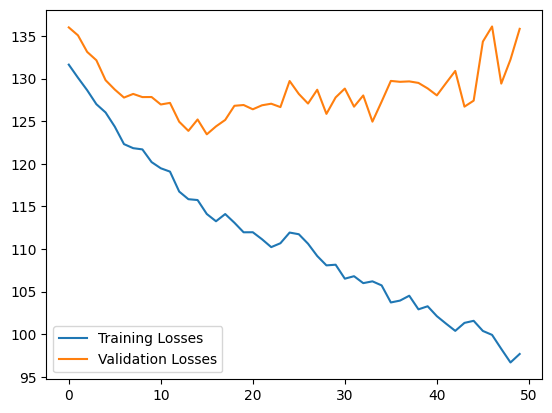

In [ ]:
train_loader_DA_diff_ID = torch.utils.data.DataLoader(
    training_set_DA_diff_ID,
    batch_size=batch_size,
    shuffle=False
)
val_loader_DA_diff_ID = torch.utils.data.DataLoader(
    val_set_DA_diff_ID,
    batch_size=1,
    shuffle=False
)

losses_train = []
losses_val = []
for epoch in range(num_epochs):
  forecasts_list =[]
  targets_list = []
  model_DA_diff_ID.train()
  epoch_loss = 0
  for i,(inputs,targets) in enumerate(train_loader_DA_diff_ID):

      inputs = inputs.float()
      targets = targets.float()

      inputs = torch.nan_to_num(inputs, nan=10.0) # Hour 2039 has nan values for some reason
      targets = torch.nan_to_num(targets, nan=10.0) # idem
      #inputs[:,:,3:] = (inputs[:,:,3:] - inputs[:,:,3:].min()) / (inputs[:,:,3:].max() - inputs[:,:,3:].min()) # NORMALIZING WORSENS PERFORMANCE
      forecasts = model_DA_diff_ID(inputs)

      forecasts_list.append(forecasts.data)
      targets_list.append(targets.data)
      #print(forecasts.shape,targets.shape)
      loss = criterion(forecasts,targets)

      optimizer_DA_diff_ID.zero_grad()
      loss.backward()
      optimizer_DA_diff_ID.step()

      epoch_loss += loss.item()

  epoch_loss_avg_train = epoch_loss/(i+1)
  losses_train.append(epoch_loss_avg_train)

  model_DA_diff_ID.eval()
  epoch_loss_val = 0
  with torch.no_grad():
    for i,(inputs,targets) in enumerate(val_loader_DA_diff_ID):

        inputs = inputs.float()
        targets = targets.float()
        #inputs[:,:,3:] = (inputs[:,:,3:] - inputs[:,:,3:].min()) / (inputs[:,:,3:].max() - inputs[:,:,3:].min())
        forecasts = model_DA_diff_ID(inputs)
        loss = criterion(forecasts,targets)

        epoch_loss_val += loss.item()

  epoch_loss_avg_eval = epoch_loss_val/(i+1)
  losses_val.append(epoch_loss_avg_eval)

  print(f'DA_diff_ID Epoch [{epoch+1}/{num_epochs}], Loss train: {epoch_loss_avg_train:.4f}, Loss val: {epoch_loss_avg_eval:.4f}')

plt.plot(losses_train,label='Training Losses')
plt.plot(losses_val,label='Validation Losses')
plt.legend()
plt.show()

Mean Loss over DA val set: 841.11536
Mean Loss over ID val set: 1028.6631
Mean Loss over DA_diff_ID val set: 135.85208


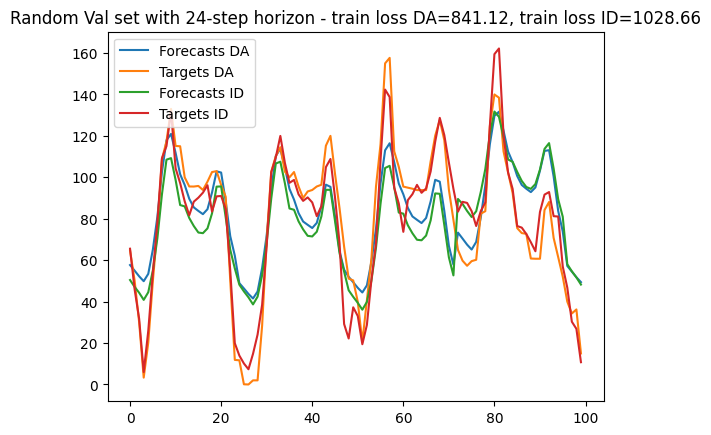

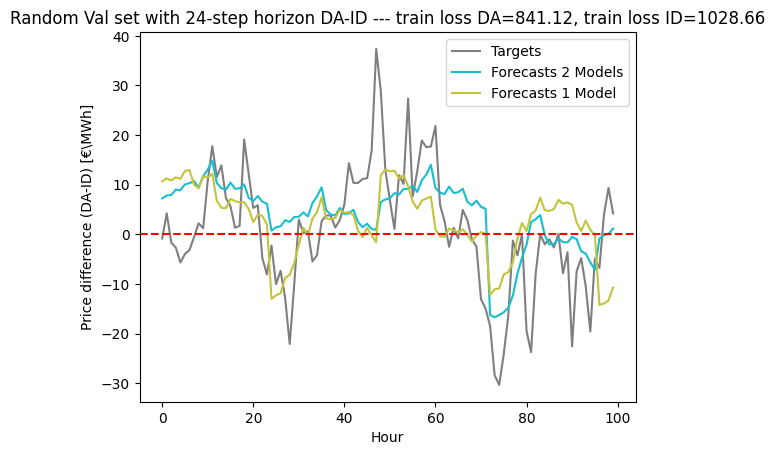

In [ ]:
forecasts_DA = []
targets_DA = []
losses_DA = []
forecasts_ID = []
targets_ID = []
losses_ID = []
forecasts_DA_diff_ID = []
targets_DA_diff_ID = []
losses_DA_diff_ID = []
model_DA.eval()
for inputs,target in val_loader_DA:
  inputs = inputs.float()
  target = target.float()
  #inputs = inputs.unsqueeze(-1)
  forecast = model_DA(inputs)
  forecasts_DA.append(forecast.data)
  targets_DA.append(target.data)
  loss = criterion(forecast,target)
  #print(loss.data)
  losses_DA.append(loss.data)

model_ID.eval()
for inputs,target in val_loader_ID:
  inputs = inputs.float()
  target = target.float()
  #inputs = inputs.unsqueeze(-1)
  forecast = model_ID(inputs)
  forecasts_ID.append(forecast.data)
  targets_ID.append(target.data)
  loss = criterion(forecast,target)
  #print(loss.data)
  losses_ID.append(loss.data)

model_DA_diff_ID.eval()
for inputs,target in val_loader_DA_diff_ID:
  inputs = inputs.float()
  target = target.float()
  #inputs = inputs.unsqueeze(-1)
  forecast = model_DA_diff_ID(inputs)
  forecasts_DA_diff_ID.append(forecast.data)
  targets_DA_diff_ID.append(target.data)
  loss = criterion(forecast,target)
  #print(loss.data)
  losses_DA_diff_ID.append(loss.data)


print('Mean Loss over DA val set:', np.mean(losses_DA))
print('Mean Loss over ID val set:', np.mean(losses_ID))
print('Mean Loss over DA_diff_ID val set:', np.mean(losses_DA_diff_ID))

prices = {1:'DA',2:'ID'}
for i,(forecasts,targets) in enumerate(zip([forecasts_DA,forecasts_ID],[targets_DA,targets_ID])):
  #forecasts = output_scalers[i].inverse_transform(np.array(forecasts).reshape(-1,1))
  #targets = output_scalers[i].inverse_transform(np.array(targets).reshape(-1,1))
  forecasts = torch.cat(forecasts, axis=1).flatten()
  targets = torch.cat(targets ,axis=1).flatten()
  plt.plot(forecasts[:100],label=f'Forecasts {prices[i+1]}')
  plt.plot(targets[:100],label=f'Targets {prices[i+1]}')

plt.title(f'Random Val set with 24-step horizon - train loss DA={np.mean(losses_DA):.2f}, train loss ID={np.mean(losses_ID):.2f}')
plt.legend()
plt.show()

labels = {1:'Targets',2:'Forecasts 2 Models'}
colors = {1:'#7F7F7F',2:'#16BECF'}
for i,(DA,ID) in enumerate(zip([targets_DA,forecasts_DA],[targets_ID,forecasts_ID])):
    #DA = output_scalers[0].inverse_transform(np.array(DA).reshape(-1,1))
    #ID = output_scalers[1].inverse_transform(np.array(ID).reshape(-1,1))
    DA = torch.cat(DA, axis=1).flatten()
    ID = torch.cat(ID, axis=1).flatten()
    DA_diff_ID = DA-ID
    plt.plot(DA_diff_ID[:100],color = colors[i+1],label=f'{labels[i+1]}')

#data = output_diff_scaler.inverse_transform(np.array(forecasts_DA_diff_ID).reshape(-1,1))
data = torch.cat(forecasts_DA_diff_ID, axis=1).flatten()
plt.plot(data[:100],color = '#C3C43B',label='Forecasts 1 Model')


plt.axhline(0,linestyle='--',color='r')
plt.title(f'Random Val set with 24-step horizon DA-ID --- train loss DA={np.mean(losses_DA):.2f}, train loss ID={np.mean(losses_ID):.2f}')
plt.ylabel('Price difference (DA-ID) [€\MWh]')
plt.xlabel('Hour')
plt.legend()
plt.show()


(1656,)
Accuracies of 1 model --> Sign: 0.5845410628019324 Abs Values of matches: 6.8645153 Abs Values of mismatches: 11.050513
Average and std price paid for mismatch: 6.7513514 7.3046384 Average and std price received for match: 9.543048 8.845474
1656


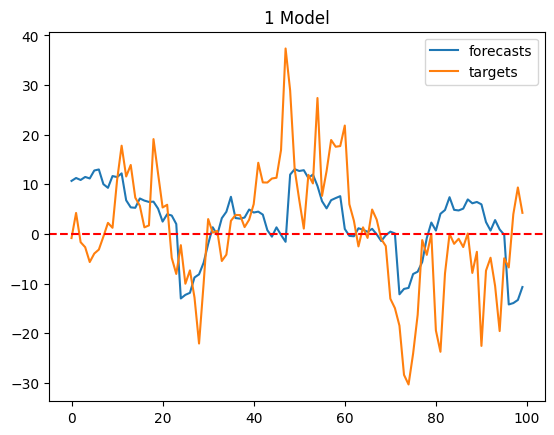

(1656,)
Accuracies of 2 model --> Sign: 0.5827294685990339 Abs Values of matches: 8.760363 Abs Values of mismatches: 16.178463
Average and std price paid for mismatch: 7.026511 7.4030256 Average and std price received for match: 9.354693 8.847021
1656


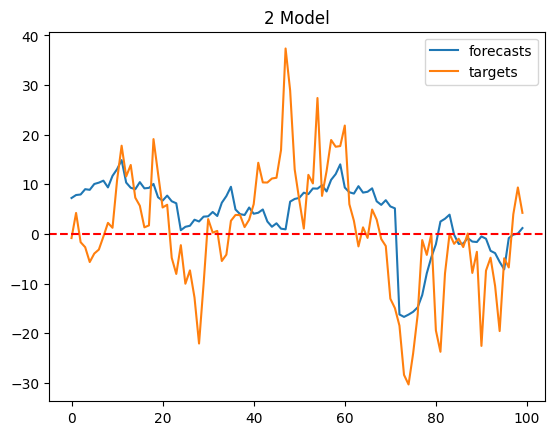

In [ ]:
# defining accuracy as diff forecasts having same sign as diff targets:
def accuracy(forecasts,targets):
  forecasts = forecasts.numpy()
  targets = targets.numpy()
  print(forecasts.shape)
  temp = forecasts*targets/np.abs(forecasts*targets)

  temp[temp==-1]=0 # masking the -1 with 0 because the correct ones are only the value 1
  accuracy_of_sign  = np.sum(temp)/len(forecasts)

  matches = temp==1
  mismatches = temp==0
  diff_values_matches = np.abs(targets[matches] - forecasts[matches])
  diff_values_mismatches = np.abs(targets[mismatches] - forecasts[mismatches])
  avg_price_paid_mismatches = np.mean(np.abs(targets[mismatches])) # forecasts is the diff between the DA and ID which is what you pay if you don't forecast correctly the sign difference (mismatch)
  avg_price_recieved_matches = np.mean(np.abs(targets[matches])) # forecasts is the diff between the DA and ID which is what you get paid if you do forecast correctly the sign difference (match)
  std_price_paid_mismatches = np.std(np.abs(targets[mismatches]))
  std_price_recieved_matches = np.std(np.abs(targets[matches]))

  return accuracy_of_sign, np.mean(diff_values_matches), np.mean(diff_values_mismatches), avg_price_paid_mismatches,avg_price_recieved_matches, std_price_paid_mismatches, std_price_recieved_matches

# forecasts for 2 models version
#forecasts_DA = output_scalers[0].inverse_transform(np.array(forecasts_DA).reshape(-1,1))
#forecasts_ID = output_scalers[1].inverse_transform(np.array(forecasts_ID).reshape(-1,1))
forecasts_2_models = torch.cat(forecasts_DA, axis=1).flatten() - torch.cat(forecasts_ID, axis=1).flatten()
targets_2_models = torch.cat(targets_DA, axis=1).flatten() - torch.cat(targets_ID, axis=1).flatten()

# forecasts for 1 model version
forecasts_1_model = torch.cat(forecasts_DA_diff_ID, axis=1).flatten()
targets_1_model = torch.cat(targets_DA_diff_ID, axis=1).flatten()
#forecasts_1_model = output_diff_scaler.inverse_transform(np.array(forecasts_DA_diff_ID).reshape(-1,1))
#targets = output_diff_scaler.inverse_transform(np.array(targets_DA_diff_ID).reshape(-1,1))
for i,(forecasts,targets) in enumerate(zip([forecasts_1_model,forecasts_2_models],[targets_1_model,targets_2_models])):

  accuracy_1_model_signs, accuracy_1_model_matches, accuracy_1_model_mismatches, avg_price_paid_mismatches,avg_price_recieved_matches, std_price_paid_mismatches, std_price_recieved_matches = accuracy(forecasts,targets)
  print(f'Accuracies of {i+1} model -->','Sign:', accuracy_1_model_signs, 'Abs Values of matches:',accuracy_1_model_matches, 'Abs Values of mismatches:',accuracy_1_model_mismatches)
  print('Average and std price paid for mismatch:',avg_price_paid_mismatches,std_price_paid_mismatches,'Average and std price received for match:',avg_price_recieved_matches,std_price_recieved_matches)
  print(len(forecasts))

  plt.plot(forecasts[:100],label='forecasts')
  plt.plot(targets[:100],label='targets')
  plt.axhline(0,linestyle='--',color='r')
  plt.title(f'{i+1} Model')
  plt.legend()
  plt.show()



In [ ]:
def revenues(forecasts,targets):

  forecasts = forecasts.numpy()
  targets = targets.numpy()
  temp = forecasts*targets/np.abs(forecasts*targets)
  revenues  = np.sum(temp*np.abs(targets))
  accum_revenues  = np.cumsum(temp*np.abs(targets))

  return accum_revenues, revenues

labels = {1:'2 models',2:'1 model'}
for i,forecasts in enumerate([forecasts_2_models,forecasts_1_model]):

  #forecasts = torch.cat([forecasts.flatten() for forecasts in forecast])
  accum_revenues, revenues_model = revenues(forecasts,targets)
  print(f'Revenues {labels[i+1]}',revenues_model)

Revenues 2 models 4171.96
Revenues 1 model 4592.7397


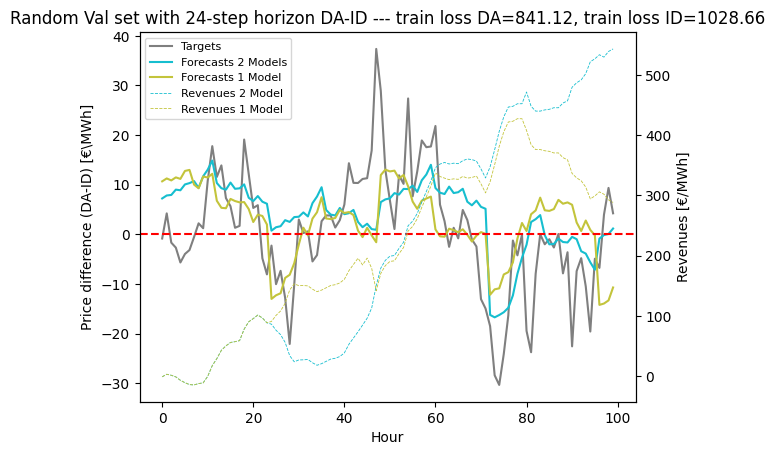

In [ ]:

labels = {1:'Targets',2:'Forecasts 2 Models'}
colors = {1:'#7F7F7F',2:'#16BECF'}
fig,ax1 = plt.subplots()
ax2.plot(accum_revenues_2_models[:100],'--',color = '#16BECF',linewidth=0.6,label='Revenues 2 Model',zorder=1)
for i,(DA,ID) in enumerate(zip([targets_DA,forecasts_DA],[targets_ID,forecasts_ID])):
    #DA = output_scalers[0].inverse_transform(np.array(DA).reshape(-1,1))
    #ID = output_scalers[1].inverse_transform(np.array(ID).reshape(-1,1))
    DA = torch.cat(DA, axis=1).flatten()
    ID = torch.cat(ID, axis=1).flatten()
    DA_diff_ID = DA-ID
    ax1.plot(DA_diff_ID[:100],color = colors[i+1],label=f'{labels[i+1]}',zorder=2)

ax2 = ax1.twinx()
accum_revenues_2_models, revenues_2_models = revenues(forecasts_2_models,targets)
accum_revenues_1_model, revenues_1_model = revenues(forecasts_1_model,targets)

#data = output_diff_scaler.inverse_transform(np.array(forecasts_DA_diff_ID).reshape(-1,1))
data = torch.cat(forecasts_DA_diff_ID, axis=1).flatten()
ax2.plot(accum_revenues_2_models[:100],'--',color = '#16BECF',linewidth=0.6,label='Revenues 2 Model',zorder=1)
ax1.plot(data[:100],color = '#C3C43B',label='Forecasts 1 Model',zorder=2)
ax2.plot(accum_revenues_1_model[:100],'--',color = '#C3C43B',linewidth=0.6,label='Revenues 1 Model',zorder=1)



ax1.axhline(0,linestyle='--',color='r')
plt.title(f'Random Val set with 24-step horizon DA-ID --- train loss DA={np.mean(losses_DA):.2f}, train loss ID={np.mean(losses_ID):.2f}')
ax1.set_ylabel('Price difference (DA-ID) [€\MWh]')
ax2.set_ylabel('Revenues [€/MWh]')
ax1.set_xlabel('Hour')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left',fontsize=8)
#ax2.legend(fontsize=7)
fig.show()

In [ ]:
temp = forecasts_1_model.numpy()*targets.numpy()/np.abs(forecasts_1_model.numpy()*targets.numpy())
hourly_revs = temp*np.abs(forecasts_1_model.numpy())
print(hourly_revs)
print(np.cumsum(hourly_revs))
print(np.cumsum([1,-1,1,1]))

[-1.  1. -1. ... -1. -1. -1.]
[-10.679523    11.264496   -10.865874   ...  -0.28220153  -1.1578778
  -1.0700161 ]
[-1.0679523e+01  5.8497238e-01 -1.0280902e+01 ...  2.0591294e+03
  2.0579714e+03  2.0569014e+03]
[1 0 1 2]
